**Modelo de analitíca para la detección de Fraude**

Natalia Lenis

DataKnow - Científico de Datos

### Importando librerias 
Se importan las librerias mas usadas para el desarollo de
modelos de analitíca mediante redes neuronales. 

In [1]:
#Importando librerias
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sn
from  sklearn.metrics import confusion_matrix
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout
from tensorflow.keras.optimizers import SGD

### Carga de datos
Se cargan los datos del dataset desde el Google Drive


In [78]:
##Importando desde el drive los archivos de training data y testing data
from google.colab import drive
drive.mount('/content/drive')
PATH = '/content/drive/My Drive/fraude/data'
train=pd.read_csv(PATH+"train.csv")
test=pd.read_csv(PATH+"test.csv")
train_or=train
test_or=test

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Visualización del dataset
Se visualizan el dataframe, se hace un primer analisis e inspección de los datos
Se observa que el dataframe esta conformado por datos de diversos tipos tanto strings, como numeros enteros y flotantes. Esto representa un retro ya que se deben limpiar y estandarizar, para que pueda ser procesados por la red neuronal.

In [79]:
train

,id,FRAUDE,VALOR,HORA_AUX,Dist_max_NAL,Canal1,FECHA,COD_PAIS,CANAL,DIASEM,DIAMES,FECHA_VIN,OFICINA_VIN,SEXO,SEGMENTO,EDAD,INGRESOS,EGRESOS,NROPAISES,Dist_Sum_INTER,Dist_Mean_INTER,Dist_Max_INTER,NROCIUDADES,Dist_Mean_NAL,Dist_HOY,Dist_sum_NAL
0,9000000001,1,0.00,13,659.13,ATM_INT,20150501,US,ATM_INT,5,1,20120306.0,392.0,M,Personal Plus,29.0,1200000.0,1200000.0,1,NaN,NaN,NaN,6,474.94,4552.41,5224.36
1,9000000002,1,0.00,17,594.77,ATM_INT,20150515,US,ATM_INT,5,15,20050415.0,716.0,M,Personal Plus,29.0,5643700.0,500000.0,1,NaN,NaN,NaN,5,289.99,4552.41,2029.90
2,9000000003,1,0.00,13,659.13,ATM_INT,20150501,US,ATM_INT,5,1,20120306.0,392.0,M,Personal Plus,29.0,1200000.0,1200000.0,1,NaN,NaN,NaN,6,474.94,4552.41,5224.36
3,9000000004,1,0.00,13,659.13,ATM_INT,20150501,US,ATM_INT,5,1,20120306.0,392.0,M,Personal Plus,29.0,1200000.0,1200000.0,1,NaN,NaN,NaN,6,474.94,4552.41,5224.36
4,9000000005,1,0.00,0,1.00,ATM_INT,20150510,CR,ATM_INT,0,10,20141009.0,788.0,M,Personal,25.0,0.0,0.0,1,NaN,NaN,NaN,1,NaN,1482.35,1.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2960,622529101,1,993430.04,19,180.65,POS,20150519,US,POS,2,19,19740401.0,442.0,F,Preferencial,48.0,103918285.0,95475378.0,4,8944.83,2236.21,3646.67,4,96.86,4552.41,484.30
2961,2043206272,0,9957.05,10,318.50,POS,20150524,US,POS,0,24,19970616.0,611.0,F,Preferencial,35.0,23625000.0,5000000.0,3,27648.32,3949.76,4552.41,11,82.67,4552.41,2810.75
2962,2943206272,0,9957.05,10,318.50,POS,20150524,US,POS,0,24,19970616.0,611.0,F,Preferencial,35.0,23625000.0,5000000.0,3,27648.32,3949.76,4552.41,11,82.67,4552.41,2810.75
2963,3136302872,0,996191.64,15,234.42,POS,20150513,US,MCI,3,13,20000609.0,534.0,F,PYME,34.0,56666000.0,37600750.0,1,NaN,NaN,NaN,3,219.46,4552.41,1316.79


In [80]:
valores=train['FRAUDE'].value_counts()
valores=np.array(valores)
valores

array([2234,  731])

Graficando las clase Fraude, se observa que son mas los datos correspondientes a caso de NO FRAUDE, que de FRAUDE, lo que implica un reto y el modelo a entrenar debe ser sensible a los casos positivos. 

Text(0.5, 1.0, 'Train Losscs vs Accuracy')

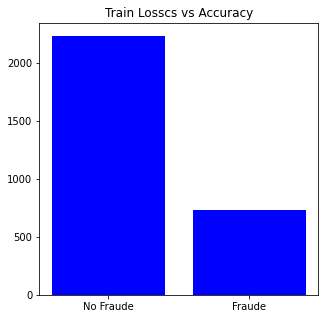

In [81]:
# "Loss"
fig, bx = plt.subplots(1,1, figsize=(5,5))

# Graficando las líneas de interés
bx.bar([0,1],valores,color='b',tick_label=['No Fraude','Fraude'])
bx.set_title('Train Losscs vs Accuracy', fontsize=12)


### Limpieza del Dataset
Como se menciono en la sección anterior el dataset se debe limpiar y estandarizar, para esto como primera medida se opto por eliminar algunas columnas del dataframe, columnas que no se consideran tan relevantes al momento de entrenar el modelo. La selección de estas columnas fue determinada por los procesos de entrenamiento, en una primera instancia se entreno el modelo con todas las columnas pero los resultados eran pobres e inadecuados, se fuerón eliminando poco a poco y los resultados mejorarón notablemente. 

Paso a seguir normalizamos las columnas que contiene un gran rango de números, las cuales son VALOR,INGRESOS,EGRESOS, la normalización que se escogio fue la Z-SCORE, la cual ubica los valores en un rango de [-1,1]. Mediante una función lambda se aplica. 

Asi mismo, es importante eliminar valores NAN que podria tener el Dataset, se identifica que diferentes filas en común persisten valores nulos, por lo que se selecciona una columna del dataframe y se eliminan. 

In [82]:
train = train.drop(['id','Dist_max_NAL','Dist_Sum_INTER','Dist_Mean_INTER','Dist_Max_INTER','Dist_Mean_NAL','Dist_HOY','Dist_sum_NAL','FECHA','FECHA_VIN','OFICINA_VIN'],axis=1)
cols_to_norm = ['VALOR','INGRESOS','EGRESOS']
train[cols_to_norm] = train[cols_to_norm].apply(lambda x: (x - x.mean()) / (x.std()))
train=train.dropna(subset=['SEGMENTO'])

In [83]:
train

,FRAUDE,VALOR,HORA_AUX,Canal1,COD_PAIS,CANAL,DIASEM,DIAMES,SEXO,SEGMENTO,EDAD,INGRESOS,EGRESOS,NROPAISES,NROCIUDADES
0,1,-0.510746,13,ATM_INT,US,ATM_INT,5,1,M,Personal Plus,29.0,-0.235769,-0.118241,1,6
1,1,-0.510746,17,ATM_INT,US,ATM_INT,5,15,M,Personal Plus,29.0,-0.156942,-0.129570,1,5
2,1,-0.510746,13,ATM_INT,US,ATM_INT,5,1,M,Personal Plus,29.0,-0.235769,-0.118241,1,6
3,1,-0.510746,13,ATM_INT,US,ATM_INT,5,1,M,Personal Plus,29.0,-0.235769,-0.118241,1,6
4,1,-0.510746,0,ATM_INT,CR,ATM_INT,0,10,M,Personal,25.0,-0.257056,-0.137661,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2960,1,0.496841,19,POS,US,POS,2,19,F,Preferencial,48.0,1.586346,1.407458,4,4
2961,0,-0.500647,10,POS,US,POS,0,24,F,Preferencial,35.0,0.162027,-0.056744,3,11
2962,0,-0.500647,10,POS,US,POS,0,24,F,Preferencial,35.0,0.162027,-0.056744,3,11
2963,0,0.499642,15,POS,US,MCI,3,13,F,PYME,34.0,0.748140,0.470848,1,3


Para este punto el dataset se ve ordenado, sin embargo hay variables del tipo objeto o string, que no pueden ser procesados por la red neuronal por lo que se deben codificar. Para la codificación de las variables se selecciona del dataset todas aquellas que sean de tipo objeto, se almacenan en una lista, paso a seguir se recorre las lista y se transforman mediante la función labelEncoder de sklearn.

In [84]:
train.dtypes
obj= train.select_dtypes(include = "object").columns
print (obj)
label_encoder = preprocessing.LabelEncoder()
for label in obj:
  train[label] = label_encoder.fit_transform(train[label].astype(str))

Index(['Canal1', 'COD_PAIS', 'CANAL', 'SEXO', 'SEGMENTO'], dtype='object')


El dataset se encuentra listo para ser procesado por una red neuronal

In [85]:
train

,FRAUDE,VALOR,HORA_AUX,Canal1,COD_PAIS,CANAL,DIASEM,DIAMES,SEXO,SEGMENTO,EDAD,INGRESOS,EGRESOS,NROPAISES,NROCIUDADES
0,1,-0.510746,13,0,27,0,5,1,1,4,29.0,-0.235769,-0.118241,1,6
1,1,-0.510746,17,0,27,0,5,15,1,4,29.0,-0.156942,-0.129570,1,5
2,1,-0.510746,13,0,27,0,5,1,1,4,29.0,-0.235769,-0.118241,1,6
3,1,-0.510746,13,0,27,0,5,1,1,4,29.0,-0.235769,-0.118241,1,6
4,1,-0.510746,0,0,6,0,0,10,1,3,25.0,-0.257056,-0.137661,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2960,1,0.496841,19,1,27,2,2,19,0,5,48.0,1.586346,1.407458,4,4
2961,0,-0.500647,10,1,27,2,0,24,0,5,35.0,0.162027,-0.056744,3,11
2962,0,-0.500647,10,1,27,2,0,24,0,5,35.0,0.162027,-0.056744,3,11
2963,0,0.499642,15,1,27,1,3,13,0,2,34.0,0.748140,0.470848,1,3


### Generación de datos para entrenamiento

Para generar los datos de entrenamiento, dividimos del dataset la columna FRAUDE ya que esta corresponde a la salida (Y), y los datos restantes seran los de entrada (X).

Los datos se deben dividir en dos grupos TRAIN, TEST, esto con el objetivo de tener datos de prueba, que pérmitan evaluar el desempeño del modelo. Esta división se realiza con la función train_test_split, se le configura el parametro de división de 0.3, lo que indica que un 30% de los datos se usaran para TEST y el 70% restante para TRAIN. 

In [86]:
y = train['FRAUDE']
x = train.drop(['FRAUDE'],axis=1)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.3, random_state = 0)

In [87]:
x_train

,VALOR,HORA_AUX,Canal1,COD_PAIS,CANAL,DIASEM,DIAMES,SEXO,SEGMENTO,EDAD,INGRESOS,EGRESOS,NROPAISES,NROCIUDADES
2853,0.359966,17,1,27,1,0,3,1,5,56.0,0.009028,-0.137661,2,2
730,1.976301,1,1,27,2,2,5,0,4,36.0,-0.119393,-0.132806,2,5
1161,-0.346087,16,1,27,1,4,21,1,5,46.0,0.186418,0.064632,3,7
1259,-0.326030,23,0,23,0,4,21,0,4,31.0,-0.203839,-0.129570,3,1
410,-0.010059,15,0,21,0,3,6,0,4,28.0,-0.181577,-0.127951,4,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
785,0.540336,2,0,27,0,3,27,0,4,36.0,-0.132883,-0.072928,2,8
857,-0.395227,8,1,27,2,0,3,1,4,43.0,-0.163039,-0.100439,2,3
1675,-0.245489,3,0,26,0,3,27,1,4,59.0,-0.115144,-0.137661,1,1
2630,-0.444817,11,1,27,2,0,3,0,5,38.0,-0.026449,-0.105294,1,8


### Entrenamiento Modelo


Para la creación del modelo se implementan 5 Capas densas, las primeras con función de activación 'ReLU' y la ultima con función de activación 'Sigmoid', ya que el problema es de clasificación binaria, los parametros como número de neuronas se fueron ajustando a medida que se entrenaba el modelo. El parametro de Dropout se implementa como estrategia para evitar Over-fitting.

In [88]:
model = Sequential([
Dense(input_dim = x_train.shape[1], units = 100, activation = 'relu'),
Dense(units = 60, activation = 'relu'),
Dropout(0.5),
Dense(units = 30, activation = 'relu'),
Dense(units = 10, activation = 'relu'),
Dense(units =1, activation = 'sigmoid'),])

Se utiliza el optimizador Adam que se destaca por su excelente desempeño y la función de loss, se selecciona binary_crossentropy, ya que es un problema de clasificación binaria. 

Se guarda el modelo para su posterior uso.

In [89]:
optimizador=keras.optimizers.Adam(learning_rate=(0.001))
model.compile(optimizer = optimizador, loss = 'binary_crossentropy', metrics = ['accuracy'])
history=model.fit(x_train, y_train, batch_size = 10, epochs = 100)
model.save(PATH+'fraude.h5', history)

Epoch 1/100
206/206 [==============================] - 1s 3ms/step - loss: 0.6505 - accuracy: 0.7221
Epoch 2/100
206/206 [==============================] - 1s 3ms/step - loss: 0.5499 - accuracy: 0.7522
Epoch 3/100
206/206 [==============================] - 1s 3ms/step - loss: 0.5228 - accuracy: 0.7648
Epoch 4/100
206/206 [==============================] - 1s 3ms/step - loss: 0.5208 - accuracy: 0.7663
Epoch 5/100
206/206 [==============================] - 1s 3ms/step - loss: 0.4828 - accuracy: 0.7818
Epoch 6/100
206/206 [==============================] - 1s 3ms/step - loss: 0.4734 - accuracy: 0.7823
Epoch 7/100
206/206 [==============================] - 1s 3ms/step - loss: 0.4501 - accuracy: 0.7993
Epoch 8/100
206/206 [==============================] - 1s 2ms/step - loss: 0.4341 - accuracy: 0.8124
Epoch 9/100
206/206 [==============================] - 1s 3ms/step - loss: 0.4295 - accuracy: 0.8217
Epoch 10/100
206/206 [==============================] - 1s 3ms/step - loss: 0.4147 - accura

Una vez finalizado el entrenamiento se visualiza en una grafica, las curvas de loss y accuracy para observar su comportamiento, se espera que la grafica de loss sea descendente y la de accuracy accendente.

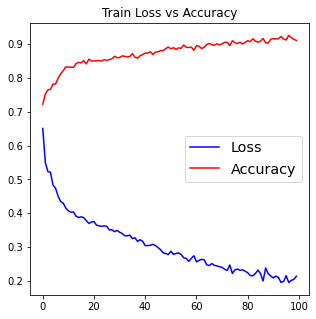

In [90]:
# "Loss"
fig, bx = plt.subplots(1,1, figsize=(5,5))

# Graficando las líneas de interés
bx.plot(history.history['loss'],color='b')
bx.plot(history.history['accuracy'],color='r')
bx.set_title('Train Loss vs Accuracy', fontsize=12)
bx.legend(['Loss', 'Accuracy'], loc='best', fontsize='x-large')

In [91]:
score = model.evaluate(x_test,y_test)
print(score)

28/28 [==============================] - 0s 2ms/step - loss: 0.3460 - accuracy: 0.8618
[0.34604427218437195, 0.8618346452713013]


In [92]:
y_prediction = model.predict(x_test)
test_array = np.array(y_test)
unique, counts = np.unique(test_array, return_counts=True)
dict(zip(unique, counts))

{0: 664, 1: 219}

### Evaluación del modelo

Se evalua el modelo mediante una matrix de confusión, que nos permite ver los aciertos de la red y obtener metricas como accuracy, precision, recall, F1-Score.

Text(0.5, 33.0, 'Predict Label')

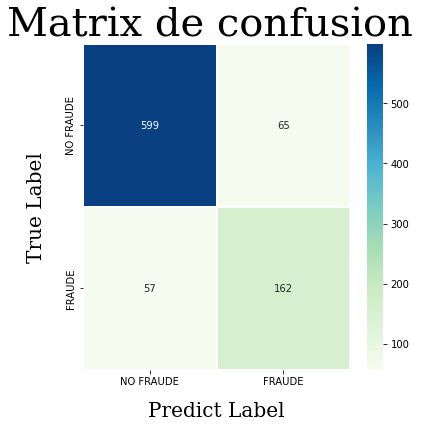

In [93]:
cm=confusion_matrix(test_array,y_prediction.round())
tn, fp, fn, tp = confusion_matrix(test_array,y_prediction.round()).ravel()
resultado = pd.DataFrame(cm, index=['NO FRAUDE','FRAUDE'],columns=['NO FRAUDE','FRAUDE'])
fig = plt.figure(figsize= (6,6))
ax = fig.add_subplot(1,1,1)
sn.heatmap(resultado, annot=True, linewidths=1, linecolor= 'white',fmt= 'd', cmap="GnBu")
font= {'family': 'serif',
     'color': 'darkred',
    'weight': 'normal',
    'size':14}
ax.set_title("Matrix de confusion ",fontdict ={'family': 'serif','color': 'black','weight': 'normal','size':40})
ax.set_ylabel("True Label", labelpad=20, fontdict={'family': 'serif','color': 'black','weight': 'normal','size':20})
ax.set_xlabel("Predict Label", labelpad=15, fontdict={'family': 'serif','color': 'black','weight': 'normal','size':20})

In [94]:
precision=tp/(tp+fp)
recall=tp/(tp+fn)
F1 = (2*precision*recall)/(precision+recall)
accuracy=tp/(tp+fn+fp)
print('\n Metricas del sistema: \n Accuracy:%f \n Precision:%f  \n Recall:%f  \n F1-Score:%f '%(accuracy,precision,recall,F1))


 Metricas del sistema: 
 Accuracy:0.570423 
 Precision:0.713656  
 Recall:0.739726  
 F1-Score:0.726457 


### Evaluando datos TEST

In [95]:
test=test[train.columns]
test

,FRAUDE,VALOR,HORA_AUX,Canal1,COD_PAIS,CANAL,DIASEM,DIAMES,SEXO,SEGMENTO,EDAD,INGRESOS,EGRESOS,NROPAISES,NROCIUDADES
0,NaN,42230.09,18,POS,US,POS,5,15,F,Personal Plus,46,20000000,10000000,1,1
1,NaN,143202.65,20,POS,US,MCI,3,6,F,Preferencial,56,11000000,4500000,3,2
2,NaN,243591.25,2,ATM_INT,EC,ATM_INT,0,17,F,Personal Plus,33,9000000,4000000,3,7
3,NaN,238267.40,20,ATM_INT,EC,ATM_INT,5,8,F,Personal Plus,53,2300000,500000,1,1
4,NaN,490403.58,13,ATM_INT,US,ATM_INT,5,1,M,Personal,0,0,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,NaN,531534.03,13,POS,US,POS,5,1,M,Preferencial,51,19327667,3000000,1,4
96,NaN,52035.08,11,POS,AW,POS,0,3,M,Preferencial,40,35500000,2000000,2,3
97,NaN,18309.04,23,POS,US,POS,5,15,M,Personal Plus,43,3100000,2000000,1,2
98,NaN,496906.75,20,ATM_INT,US,ATM_INT,6,16,M,Personal Plus,40,24000000,10500000,1,3


In [ ]:
cols_to_norm = ['VALOR','INGRESOS','EGRESOS']
test[cols_to_norm] = test[cols_to_norm].apply(lambda x: (x - x.mean()) / (x.std()))

In [ ]:
test.dtypes
obj= test.select_dtypes(include = "object").columns
print (obj)
label_encoder = preprocessing.LabelEncoder()
for label in obj:
  test[label] = label_encoder.fit_transform(test[label].astype(str))

In [98]:
test=test.drop(['FRAUDE'],axis=1)

In [99]:
test

,VALOR,HORA_AUX,Canal1,COD_PAIS,CANAL,DIASEM,DIAMES,SEXO,SEGMENTO,EDAD,INGRESOS,EGRESOS,NROPAISES,NROCIUDADES
0,-0.637636,18,1,7,2,5,15,0,3,46,0.631733,0.836517,1,1
1,-0.449572,20,1,7,1,3,6,0,4,56,-0.004265,0.074308,3,2
2,-0.262597,2,0,3,0,0,17,0,3,33,-0.145598,0.005016,3,7
3,-0.272513,20,0,3,0,5,8,0,3,53,-0.619064,-0.480026,1,1
4,0.197095,13,0,7,0,5,1,1,2,0,-0.781597,-0.549317,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,0.273702,13,1,7,2,5,1,1,4,51,0.584222,-0.133567,1,4
96,-0.619374,11,1,0,2,0,3,1,4,40,1.727064,-0.272151,2,3
97,-0.682189,23,1,7,2,5,15,1,3,43,-0.562530,-0.272151,1,2
98,0.209208,20,0,7,0,6,16,1,3,40,0.914399,0.905809,1,3


In [ ]:
test_evaluado = model.predict(test)
test_or['FRAUDE'] = test_evaluado.round()

In [101]:
test_or

,id,FRAUDE,VALOR,HORA_AUX,Dist_max_COL,Dist_max_INTER,Canal1,FECHA_FRAUDE,COD_PAIS,CANAL,FECHA,DIASEM,DIAMES,FECHA_VIN,OFICINA_VIN,SEXO,SEGMENTO,EDAD,INGRESOS,EGRESOS,NROPAISES,Dist_Sum_INTER,Dist_Mean_INTER,Dist_Max_INTER,NROCIUDADES,Dist_Sum_NAL,Dist_Mean_NAL,Dist_HOY,Dist_sum_NAL,Dist_mean_NAL,Dist_sum_INTER,Dist_mean_INTER
0,98523068,0.0,42230.09,18,1.00,1.00,POS,20150515,US,POS,20150515,5,15,20150316,611,F,Personal Plus,46,20000000,10000000,1,NaN,NaN,NaN,1,NaN,NaN,4552.41,1.00,1.00,1.00,1.00
1,300237898,1.0,143202.65,20,614.04,7632.97,POS,20150506,US,MCI,20150506,3,6,19890814,961,F,Preferencial,56,11000000,4500000,3,24370.75,6092.69,7632.97,2,1228.07,614.04,4552.41,1228.07,614.04,24370.75,6092.69
2,943273308,1.0,243591.25,2,286.84,2443.14,ATM_INT,20150517,EC,ATM_INT,20150517,0,17,20051201,218,F,Personal Plus,33,9000000,4000000,3,6974.09,1743.52,2443.14,7,1944.35,138.88,5083.41,1944.35,138.88,6974.09,1743.52
3,951645809,1.0,238267.40,20,1.00,1.00,ATM_INT,20150508,EC,ATM_INT,20150508,5,8,19990301,113,F,Personal Plus,53,2300000,500000,1,NaN,NaN,NaN,1,NaN,NaN,904.81,1.00,1.00,1.00,1.00
4,963797516,1.0,490403.58,13,1.00,1.00,ATM_INT,20150501,US,ATM_INT,20150501,5,1,19910330,85,M,Personal,0,0,0,1,NaN,NaN,NaN,1,NaN,NaN,4552.41,1.00,1.00,1.00,1.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,9970518152,0.0,531534.03,13,340.09,1.00,POS,20150501,US,POS,20150501,5,1,19890103,929,M,Preferencial,51,19327667,3000000,1,NaN,NaN,NaN,4,844.35,56.29,4552.41,844.35,56.29,1.00,1.00
96,9971748725,0.0,52035.08,11,28.59,4552.41,POS,20150503,AW,POS,20150503,0,3,19950601,527,M,Preferencial,40,35500000,2000000,2,9104.82,4552.41,4552.41,3,151.52,25.25,971.23,151.52,25.25,9104.82,4552.41
97,9979565282,1.0,18309.04,23,61.45,1.00,POS,20150515,US,POS,20150515,5,15,20150224,178,M,Personal Plus,43,3100000,2000000,1,NaN,NaN,NaN,2,122.90,61.45,4552.41,122.90,61.45,1.00,1.00
98,9979718478,1.0,496906.75,20,733.11,1.00,ATM_INT,20150516,US,ATM_INT,20150516,6,16,20090521,156,M,Personal Plus,40,24000000,10500000,1,NaN,NaN,NaN,3,1812.93,453.23,4552.41,1812.93,453.23,1.00,1.00


In [102]:
## exportamos el dataset a un tabla de excel  
writer = test_or.to_excel(PATH+'test_evaluado.xlsx',sheet_name='test_evaluado')

### Modelo 2

In [194]:
## Creacion del modelo de red neuronal 

model = Sequential()
model.add(Dense(128, input_dim=x_train.shape[1], activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation = 'sigmoid'))

sgd = SGD(lr=0.001, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(loss='binary_crossentropy', optimizer= sgd, metrics=['accuracy'])

hist= model.fit(x_train,y_train,epochs=100,batch_size=5,verbose=1)

model.save(PATH+'fraude.h5', hist)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


Epoch 1/100
412/412 [==============================] - 1s 2ms/step - loss: 0.7675 - accuracy: 0.7080
Epoch 2/100
412/412 [==============================] - 1s 2ms/step - loss: 0.5725 - accuracy: 0.7386
Epoch 3/100
412/412 [==============================] - 1s 2ms/step - loss: 0.5642 - accuracy: 0.7556
Epoch 4/100
412/412 [==============================] - 1s 2ms/step - loss: 0.5521 - accuracy: 0.7527
Epoch 5/100
412/412 [==============================] - 1s 2ms/step - loss: 0.5473 - accuracy: 0.7556
Epoch 6/100
412/412 [==============================] - 1s 2ms/step - loss: 0.5458 - accuracy: 0.7566
Epoch 7/100
412/412 [==============================] - 1s 2ms/step - loss: 0.5404 - accuracy: 0.7638
Epoch 8/100
412/412 [==============================] - 1s 2ms/step - loss: 0.5391 - accuracy: 0.7648
Epoch 9/100
412/412 [==============================] - 1s 2ms/step - loss: 0.5324 - accuracy: 0.7648
Epoch 10/100
412/412 [==============================] - 1s 2ms/step - loss: 0.5379 - accura

In [ ]:
'''
mean_value=train['Dist_Mean_NAL'].mean()
print(mean_value)
train['Dist_Mean_NAL'].fillna(value=mean_value, inplace=True)
train['Dist_Mean_NAL'].value_counts()
'''